# Example 4

## Coupled fluid–heat network with temperature- and pressure-dependent properties

In this example, a **pipe network** is solved where the **hydraulic field** and the **thermal field** are **coupled**. Unlike the previous cases:

* **Fluid properties depend on temperature and pressure**
* The **thermal field is advective**, meaning that heat is transported by the flow
* The **hydraulic conductivity is nonlinear**, depending on the flow regime
* **CoolProp** is used to evaluate thermodynamic properties
* The system is solved using a **sequential coupled scheme**

---

## Hydraulic model

### Why stiffness is nonlinear

In laminar flow, the relationship between flow and head difference is linear:

$$ 
Q \propto \Delta H
$$

However, in transitional and turbulent regimes, experimental correlations show:

$$
Q \propto (\Delta H)^n \quad (n < 1)
$$

To preserve a **matrix-based formulation**, this nonlinear law is rewritten as:

$$
Q^i = \frac{k^i}{|\Delta H^i|^{1-n}} , \Delta H^i
$$

For Hazen–Williams–type behavior:

$$
n = 0.54 \quad \Rightarrow \quad 1-n = 0.46
$$

Thus:

$$
\overline{k}^i = \frac{k^i}{|\Delta H^i|^{0.46}}
$$

This allows the nonlinear problem to be solved through **iterative updates of the stiffness**.

### Flow–head loss relationship

A **nonlinear Hazen–Williams-type formulation** is used, written in a form compatible with matrix assembly:

$$
Q^i = \overline{k}^i  \Delta H^i
$$

Here:

* $ Q^i $: flow rate in element $ i $
* $ \Delta H^i = H_k - H_j $: head difference between the two nodes
* $ \overline{k}^i $: **element stiffness (conductivity)**

> **Interpretation:**
> The stiffness plays the same role as electrical conductance in circuits or stiffness in structural mechanics:
> it controls how strongly two nodes are hydraulically connected.

where the effective element conductivity is:

$$
\overline{k}^i =
\frac{0.2784  C_{HW}^i  D_i^{2.63}}
{L_i^{0.54} |\Delta H_i|^{0.46}}
$$

In this case, the coefficient $C_{HW}$ is **not constant**, but depends on the **hydraulic regime**, which is modeled through the **Darcy friction factor**:

$$
C_{HW} =
\left(
\frac{5.335  g  \pi^2  |Q|^{-0.15}  D^{0.13}}{f}
\right)^{1/1.85}
$$

This makes the hydraulic resistance sensitive to:

* Flow velocity
* Fluid viscosity
* Pipe roughness
* Flow regime

## Thermal model (advective)

### Energy equation on the network

The thermal system is modeled as **advective energy transport**:

$$
\dot{H} = \rho(T,P)  c_p(T,P) Q  T
$$

This code uses the following notation for advective flows:

$$
F = \gamma Q \phi
$$

where
- $F$: advective flow
- $Q$: volumetric flow
- $\phi$: transported variable

A thermal system is achieved by:
- $F \rightarrow H$ (enthalpy flow)
- $\gamma \rightarrow \rho(T,P)  c_p(T,P)$
    - It can be constant or variable by means of a function
- $ Q \rightarrow $ flow rate obtained from the fluid system    
- $\phi \rightarrow T$

where:

* $c_p$ and $\rho$ depends on temperature and pressure
* Heat propagates **following the flow direction**

This leads to a **non-symmetric matrix system**, whose nodal term depends on:

$$
\gamma = \rho(T,P)  c_p(T,P)
$$

For this reason, the thermal system requires a **user-supplied `gamma` function**.

---

## Fluid–heat coupling

The coupling occurs because:

| System   | Depends on            |
| -------- | --------------------- |
| Fluid    | $\rho(T,P), \mu(T,P)$ |
| Heat     | $Q, \rho c_p$        |
| Pressure | $P = \rho g H + P_0$  |

The solution is obtained using an **iterative sequential scheme**:

1. Solve hydraulics
2. Update thermodynamic properties
3. Solve energy
4. Repeat until convergence


---

## Network geometry and connectivity

In [1]:
import numpy as np
import netsystems as ns

In [2]:
net = ns.Network()

connectivity = np.array([
    [0, 1],  
    [0, 2],  
    [1, 3],
    [2, 3],
    [2, 4],
    [3, 5],
    [4, 5],
])

net.set_connectivity(connectivity)

net.node_coordinates = np.array([
    [0.0,  0.0],
    [1.0,  1.0],
    [1.0, -1.0],
    [2.0,  0.5],
    [2.0, -0.5],
    [3.0,  0.0],
])

net.node_coordinates *= 12
net.calculate_element_lengths()

## Hydraulic system

In [3]:
fluid = ns.System("fluid", system_type="diffusive")

fluid.x_name = "H"
fluid.b_name = "C"
fluid.element_variable_name = "Q"
fluid.initial_x = np.full(net.n_nodes, 5)

fluid.known_x_nodes = np.array([5])
fluid.known_x_values = np.array([0.0])

fluid.known_b_nodes = np.array([0])
fluid.known_b_values = np.array([0.0001])

### Geometric properties

In [4]:
net.element_diameters = np.ones(net.n_elements) * 0.05

### Initial conductivity (estimate)

In [5]:
hazen_williams_coef = 110

fluid.element_conductance = (
    0.2784 * hazen_williams_coef
    * net.element_diameters**2.63
    / net.element_lengths**0.54
)

## Thermodynamic properties with CoolProp

The functions `mu_water`, `cp_water`, and `k_water` follow exactly the same logic:

* Hydrostatic pressure computed from $H$
* Evaluation with `PropsSI`
* Full dependence on $T$ and $P$

This functions are evaluated **at every iteration**, allowing the thermal system to respond to the current hydraulic state.

In [6]:
from CoolProp.CoolProp import PropsSI

In [7]:
def rho_water(net):
    g = 9.81
    
    H = net.get("H")
    T = net.get("T")

    if not hasattr(net, "iteration") or net.iteration == 0:
        rho = PropsSI("D", "T", 300.0, "P", 101325.0, "water")
        fluid.rho = np.full(net.n_nodes, rho)
    else:
        P = H * fluid.rho * g + 101325.0
        fluid.rho = PropsSI("D", "T", T, "P", P, "water")

    return fluid.rho


def mu_water(net):
    g = 9.81

    H = net.get("H")
    T = net.get("T")

    if not hasattr(net, "iteration") or net.iteration == 0:
        T_ref = 300.0
        P_ref = 101325.0
        rho_ref = PropsSI("D", "T", T_ref, "P", P_ref, "water")
        P = H * rho_ref * g + P_ref
        mu = PropsSI("V", "T", T, "P", P, "water")
    else:
        P = H * fluid.rho * g + 101325.0
        mu = PropsSI("V", "T", T, "P", P, "water")

    return mu

def cp_water(net):
    g = 9.81

    fluid   = net.systems["fluid"]
    thermal = net.systems["heat"]

    H = fluid.x
    T = thermal.x

    if not hasattr(net, "iteration") or net.iteration == 0:
        T_ref = 300.0
        P_ref = 101325.0
        rho_ref = PropsSI("D", "T", T_ref, "P", P_ref, "water")
        P = H * rho_ref * g + P_ref
        cp = PropsSI("C", "T", T, "P", P, "water")
    else:
        P = H * fluid.rho * g + 101325.0
        cp = PropsSI("C", "T", T, "P", P, "water")

    return cp

    
def k_water(net):
    g = 9.81

    fluid   = net.systems["fluid"]
    thermal = net.systems["heat"]

    H = fluid.x
    T = thermal.x

    # or 
    # H = net.get("H")
    # T = net.get("T")

    if not hasattr(net, "iteration") or net.iteration == 0:
        T_ref = 300.0
        P_ref = 101325.0
        rho_ref = PropsSI("D", "T", T_ref, "P", P_ref, "water")
        P = H * rho_ref * g + P_ref
        k = PropsSI("L", "T", T, "P", P, "water")
    else:
        P = H * fluid.rho * g + 101325.0
        k = PropsSI("L", "T", T, "P", P, "water")

    return k


### Nonlinear property-dependent conductivity

**Why element properties use averaged nodal values**

**Nodes vs elements**

In a network:

* **Primary variables** (head, temperature) are stored at **nodes**
* **Constitutive relations** act over **elements**

However, physical properties such as:

* density $ \rho $
* viscosity $ \mu $
* specific heat $ c_p $

vary continuously along the pipe.

---

**Element-averaged approximation**

To compute element quantities (Reynolds number, friction factor), properties are approximated by **averaging nodal values**:

$$
\rho_e = \frac{\rho_k + \rho_j}{2}, \quad
\mu_e  = \frac{\mu_k  + \mu_j}{2}
$$

> This approximation represents a **midpoint integration** of properties over the element.

Idea

1. Compute $\Delta H$
2. Obtain $\rho(T,P)$ and $\mu(T,P)$
3. Compute Reynolds number
4. Evaluate $f$
5. Compute $C_{HW}(Re)$
6. Build $\overline{k}$

#### Reynolds number and flow regime

The Reynolds number is computed as:

$$
Re = \frac{4 \rho |Q|}{\pi D \mu}
$$

Using element-averaged properties:

$$
Re^i =
\frac{4 \rho_e^i |Q^i|}
{\pi D_i \mu_e^i}
$$

This scalar determines the flow regime:

| Regime       | Condition                |
| ------------ | ------------------------ |
| Laminar      | $ Re < 2000 $            |
| Transitional | $ 2000 \le Re \le 4000 $ |
| Turbulent    | $ Re > 4000 $            |

---

#### Darcy friction factor

The friction factor $ f $ quantifies wall shear stress and energy dissipation.

* Laminar:

$$
  f = \frac{64}{Re}
$$

* Turbulent (Swamee–Jain):

$$
  f = \frac{0.25}{\left[\log_{10}
  \left(\frac{\varepsilon}{3.7D} + \frac{5.74}{Re^{0.9}}\right)\right]^2}
$$

* Transitional:
  Smooth polynomial interpolation (as used in EPANET)

---

## Final hydraulic stiffness expression

After computing all intermediate quantities, the final element stiffness is:

$$
\boxed{
\overline{k}^i =
\frac{
0.2784 
C_{HW}^i 
D_i^{2.63}
}{
L_i^{0.54} 
|\Delta H^i|^{0.46}
}
}
$$

This quantity is updated **at every nonlinear iteration**.


Implementation

In [27]:

def friction_factor(Re, D, eps):
    """
    Vectorized Darcy friction factor.

    Parameters
    ----------
    Re : float or array_like
        Reynolds number.
    D : float or array_like
        Pipe diameter [m].
    eps : float or array_like
        Absolute roughness [m].

    Returns
    -------
    f : ndarray
        Darcy friction factor.
    """

    # Convert to arrays (enables broadcasting)
    Re  = np.asarray(Re, dtype=float)
    D   = np.asarray(D, dtype=float)
    eps = np.asarray(eps, dtype=float)

    f = np.empty_like(Re, dtype=float)

    # Regime masks
    mask_lam = Re < 2000.0
    mask_tur = Re > 4000.0
    mask_trn = (~mask_lam) & (~mask_tur)

    # -------------------
    # Laminar
    # -------------------
    if np.any(mask_lam):
        f[mask_lam] = 64.0 / Re[mask_lam]

    # -------------------
    # Turbulent (Swamee–Jain, log10)
    # -------------------
    if np.any(mask_tur):
        aa = eps[mask_tur] / (3.7 * D[mask_tur]) \
           + 5.74 / (Re[mask_tur]**0.9)

        f[mask_tur] = 0.25 / (np.log10(aa)**2)

    # -------------------
    # Transitional
    # -------------------
    if np.any(mask_trn):
        Re_t  = Re[mask_trn]
        D_t   = D[mask_trn]
        eps_t = eps[mask_trn]

        R = Re_t / 2000.0

        Y2 = eps_t / (3.7 * D_t) + 5.74 / (Re_t**0.9)
        Y3 = -0.86859 * np.log(
            eps_t / (3.7 * D_t) + 5.74 / (4000.0**0.9)
        )

        FA = Y3**(-2)
        FB = FA * (2.0 - 0.00514215 / (Y2 * Y3))

        X1 = 7.0 * FA - FB
        X2 = 0.128 - 17.0 * FA + 2.5 * FB
        X3 = -0.128 + 13.0 * FA - 2.0 * FB
        X4 = R * (0.032 - 3.0 * FA + 0.5 * FB)

        f[mask_trn] = X1 + R * (X2 + R * (X3 + X4))

    return f
    

def nonlinear_fluid_element_conductance(net):

    fluid = net.systems["fluid"]
    H = fluid.x
    Q = fluid.element_variable
    # or
    # H = net.get("H")
    # Q = net.get("Q")
    
    L = net.element_lengths
    D = net.element_diameters
    C = net.connectivity.astype(int)

    i0, i1 = C[:, 0], C[:, 1]

    dH = H[i0] - H[i1]
    dH_abs = np.abs(dH) + 1e-12

    rho = rho_water(net)
    mu  = mu_water(net)

    rho_e = 0.5 * (rho[i0] + rho[i1])
    mu_e  = 0.5 * (mu[i0] + mu[i1])

    Re = (4.0 * rho_e * np.abs(Q)) / (np.pi * D * mu_e)

    eps = np.full(net.n_elements, 2.9e-7)
    f = friction_factor(Re, D, eps)

    C_hw = (
        5.335 * 9.81 * np.pi**2
        * np.abs(Q)**(-0.15)
        * D**0.13 / f
    ) ** (1.0 / 1.85)

    k = (
        0.2784
        * C_hw
        * D**2.63
        / L**0.54
        / dH_abs**0.46
    )

    return k
    

In [28]:
fluid.element_conductance_function = nonlinear_fluid_element_conductance

## Thermal system (advective)

In [29]:
heat = ns.System("heat", system_type="advective")

heat.x_name = "T"
heat.b_name = "heat"
heat.edge_var_name = "enthalpy_flow"
heat.initial_x = np.full(net.n_nodes, 300.0)

heat.known_x_nodes = np.array([0])
heat.known_x_values = np.array([300.0])

### Advective term

In the advective thermal system, heat is transported **by the fluid flow** along each pipe. In addition to pure advection, it is often necessary to model a **distributed heat exchange** acting along the pipe length (for example, heat gain from the environment, heat loss to the surroundings, or internal heat generation).

This distributed heat contribution is assigned **element-wise**, meaning that **each pipe (element)** receives a prescribed thermal input.

---

#### Prescribed heat flux per element

We start by defining a constant heat flux intensity:

$$
q_w = 200
$$

This value represents a **uniform heat input per unit surface area**, typically with units:

$$
[q_w] = \mathrm{W, m^{-2}}
$$

A vector is then constructed so that **every element in the network receives the same heat flux**:

$$
q_w^e = q_w \quad \forall e
$$

In the code, this is implemented as:

```python
qw = 200
heat_area = np.full(net.n_elements, qw)
```

Here, `heat_area[e] = q_w` for each element $e$.

---

#### Heat transfer surface of a pipe element

Each pipe is modeled as a **cylindrical element**. The lateral surface area of a pipe element $e$ is:

$$
A_e = \pi D_e L_e
$$

where:

* $D_e$ is the pipe diameter,
* $L_e$ is the pipe length.

This surface area represents the **contact area over which heat is exchanged**.

---

#### Total heat added to an element

The **total thermal power** assigned to element $e$ is obtained by multiplying the heat flux by the pipe surface area:

$$
\dot{Q}_e = q_w^e , A_e
$$

Substituting the expression for $A_e$:

$$
\dot{Q}_e = q_w , \pi D_e L_e
$$

This quantity has units of power:

$$
[\dot{Q}_e] = \mathrm{W}
$$

---

#### Definition of `element_property` for an advective system

In the framework, the attribute `element_property` represents an **element-wise coefficient** that enters the discretized system equations.

For an **advective thermal system**:

* `element_property[e]` is interpreted as a **distributed heat source associated with element $e$**
* It contributes to the **nodal energy balance** according to the flow direction
* Its effect is transported downstream by the fluid velocity

### Code implementation

Putting everything together, the total heat assigned to each element is computed as:

In [30]:
qw = 200
heat_area = np.full(net.n_elements, qw)

heat.element_flux = (
    heat_area
    * np.pi
    * net.element_diameters
    * net.element_lengths
)

### Gamma function 

In [31]:
def gamma_function_heat(net):
    return rho_water(net) * cp_water(net)

In [32]:
heat.nodal_gamma_function = gamma_function_heat

## Coupled solution

The solver performs:

1. Hydraulic solve (given current properties)
2. Property update via CoolProp
3. Thermal solve (advective transport)
4. Convergence check
5. Repeat until tolerance is met

In [33]:
net.add_system(fluid)
net.add_system(heat)

ns.solve_coupled_sequential(
    net,
    "fluid",
    "heat",
    tol=1e-4,
    report=True
)

[Coupled] Iter 00: ΔT = 6.822e+02
[Coupled] Iter 01: ΔT = 1.033e-01
[Coupled] Iter 02: ΔT = 3.604e-03
[Coupled] Iter 03: ΔT = 1.253e-04
[Coupled] Iter 04: ΔT = 4.347e-06


Results

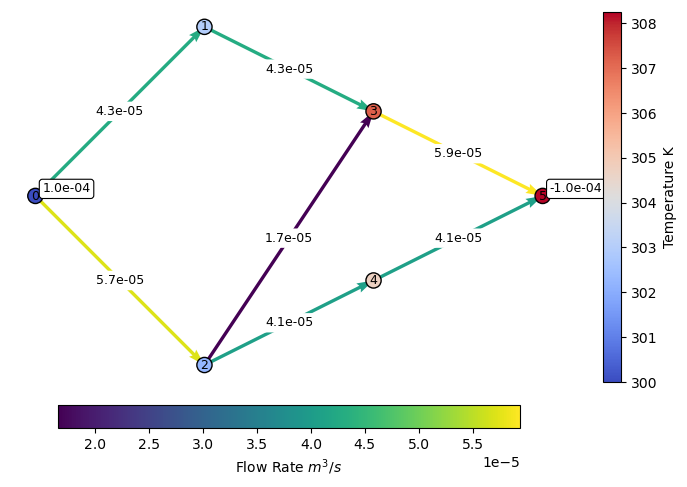

In [35]:
ns.plot_network_results(
    net,
    "Q",
    "C",
    node_values=net.get("T"),
    element_values=net.get("Q"),
    node_cmap="coolwarm",
    element_cmap="viridis",

    show_node_numbers=True,
    show_element_numbers=True,
    show_flow_arrows=True,

    show_element_values=True,
    element_value_format="{:.1e}",
    element_value_fontsize=9,
    element_value_color="black",
    element_value_bbox=True,

    show_node_demands=True,
    node_demand_format="{:.1e}",
    node_demand_fontsize=9,
    node_demand_color="black",
    node_demand_offset=(0.5, 0.5),
    node_demand_bbox=True,

    node_size=120,
    line_width=3.0,
    arrow_scale=1.0,
    arrow_width=0.006,
    figure_size=(9, 6),

    node_colorbar_label="Temperature K",
    element_colorbar_label="Flow Rate $m^3/s$",
    title=None,
    axis_off=True,

    save_figure=False,
    figure_name="figure.png",
    dpi=300,
    pad_inches=0.05,
)